In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors

from utils import FEATURES_DIR, RESULTS_DIR, SUBJECTS, NUM_TEST_STIMULI
from analyses.ridge_regression_decoding import NUM_CV_SPLITS, DECODER_OUT_DIR, calc_rsa, calc_rsa_images, calc_rsa_captions, get_fmri_data, pairwise_accuracy, ACC_MODALITY_AGNOSTIC, ACC_CAPTIONS, ACC_IMAGES, get_default_features, get_default_vision_features
from notebook_utils import add_avg_subject, create_result_graph, plot_metric_catplot, plot_metric, load_results_data, ACC_MEAN

In [2]:
all_data = load_results_data()

100%|██████████| 5220/5220 [00:03<00:00, 1697.65it/s]


In [3]:
MODEL_ORDER = ["random-flava", "vit-b-16", "vit-l-16", "resnet-18", "resnet-50", "resnet-152", "dino-base", "dino-large", "dino-giant",
               "bert-base-uncased", "bert-large-uncased", "llama2-7b", "llama2-13b", "mistral-7b", "mixtral-8x7b", "gpt2-small", "gpt2-medium", "gpt2-large", "gpt2-xl",
               "visualbert", "bridgetower-large", "clip", "flava", "imagebind", "vilt"]

all_data = all_data[all_data.model.isin(MODEL_ORDER)]
all_data

,alpha,model,subject,features,vision_features,training_mode,mask,num_voxels,metric,value,model_feat
0,100000.0,bert-base-uncased,sub-01,lang,visual_feature_mean,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.848265,bert-base-uncased_lang
1,100000.0,bert-base-uncased,sub-01,lang,visual_feature_mean,modality-agnostic,whole_brain,162649,pairwise_acc_captions,0.847143,bert-base-uncased_lang
2,100000.0,bert-base-uncased,sub-01,lang,visual_feature_mean,modality-agnostic,whole_brain,162649,pairwise_acc_images,0.873061,bert-base-uncased_lang
3,100000.0,bert-base-uncased,sub-01,lang,visual_feature_mean,modality-agnostic,whole_brain,162649,pairwise_acc_mean,0.860102,bert-base-uncased_lang
4,100000.0,bert-large-uncased,sub-01,lang,visual_feature_mean,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.833673,bert-large-uncased_lang
...,...,...,...,...,...,...,...,...,...,...,...
3939,100000.0,vit-b-16,sub-07,vision,visual_feature_mean,images,whole_brain,214739,pairwise_acc_mean,0.783367,vit-b-16_vision
3940,100000.0,vit-l-16,sub-07,vision,visual_feature_mean,images,whole_brain,214739,pairwise_acc_modality_agnostic,0.761939,vit-l-16_vision
3941,100000.0,vit-l-16,sub-07,vision,visual_feature_mean,images,whole_brain,214739,pairwise_acc_captions,0.696939,vit-l-16_vision
3942,100000.0,vit-l-16,sub-07,vision,visual_feature_mean,images,whole_brain,214739,pairwise_acc_images,0.920612,vit-l-16_vision


In [4]:
multimodal_models = all_data[all_data.features == "matched"].model.unique().tolist()

data_default_feats = all_data.copy()
for model in all_data.model.unique():
    default_feats = get_default_features(model)
    default_vision_feats = get_default_vision_features(model)
    data_default_feats = data_default_feats[((data_default_feats.model == model) & (data_default_feats.features == default_feats) & (data_default_feats.vision_features == default_vision_feats)) | (data_default_feats.model != model)]
    
data_default_feats

Selected default features for bert-base-uncased: lang
Selected default vision features for bert-base-uncased: visual_feature_mean
Selected default features for bert-large-uncased: lang
Selected default vision features for bert-large-uncased: visual_feature_mean
Selected default features for bridgetower-large: matched
Selected default vision features for bridgetower-large: visual_feature_mean
Selected default features for clip: matched
Selected default vision features for clip: visual_feature_mean
Selected default features for dino-base: vision
Selected default vision features for dino-base: visual_feature_mean
Selected default features for dino-giant: vision
Selected default vision features for dino-giant: visual_feature_mean
Selected default features for dino-large: vision
Selected default vision features for dino-large: visual_feature_mean
Selected default features for flava: matched
Selected default vision features for flava: visual_feature_cls
Selected default features for gpt2-lar

,alpha,model,subject,features,vision_features,training_mode,mask,num_voxels,metric,value,model_feat
0,100000.0,bert-base-uncased,sub-01,lang,visual_feature_mean,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.848265,bert-base-uncased_lang
1,100000.0,bert-base-uncased,sub-01,lang,visual_feature_mean,modality-agnostic,whole_brain,162649,pairwise_acc_captions,0.847143,bert-base-uncased_lang
2,100000.0,bert-base-uncased,sub-01,lang,visual_feature_mean,modality-agnostic,whole_brain,162649,pairwise_acc_images,0.873061,bert-base-uncased_lang
3,100000.0,bert-base-uncased,sub-01,lang,visual_feature_mean,modality-agnostic,whole_brain,162649,pairwise_acc_mean,0.860102,bert-base-uncased_lang
4,100000.0,bert-large-uncased,sub-01,lang,visual_feature_mean,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.833673,bert-large-uncased_lang
...,...,...,...,...,...,...,...,...,...,...,...
3939,100000.0,vit-b-16,sub-07,vision,visual_feature_mean,images,whole_brain,214739,pairwise_acc_mean,0.783367,vit-b-16_vision
3940,100000.0,vit-l-16,sub-07,vision,visual_feature_mean,images,whole_brain,214739,pairwise_acc_modality_agnostic,0.761939,vit-l-16_vision
3941,100000.0,vit-l-16,sub-07,vision,visual_feature_mean,images,whole_brain,214739,pairwise_acc_captions,0.696939,vit-l-16_vision
3942,100000.0,vit-l-16,sub-07,vision,visual_feature_mean,images,whole_brain,214739,pairwise_acc_images,0.920612,vit-l-16_vision


In [5]:
DEFAULT_FEAT_OPTIONS = ["vision", "lang", "matched"]

def calc_model_feat_order(data, feat_options=DEFAULT_FEAT_OPTIONS):
    all_model_feats = data.model_feat.unique()
    all_models = data.model.unique()
    for model in all_models:
        if model not in MODEL_ORDER:
            raise RuntimeError(f"Model missing in order: {model}")
    model_feat_order = []
    for model in MODEL_ORDER:
        for feats in feat_options:
            model_feat = f"{model}_{feats}"
            if model_feat in all_model_feats:
                model_feat_order.append(model_feat)

    return model_feat_order

# for model in MODEL_ORDER:
#     print(model, end=" ")

## Modality-agnostic decoding vs. modality-specific decoding

In [6]:
MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY = [m+'_lang' for m in multimodal_models] + [m+'_vision' for m in multimodal_models]
MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY += [m+'_vision+lang' for m in multimodal_models]

vision_models = [m for m in all_data[all_data.features == "vision"].model.unique() if len(all_data[all_data.model == m].features.unique()) == 1]
for m in multimodal_models:
    print(m, end=" ")


bridgetower-large clip flava imagebind random-flava vilt visualbert 

### Model performance ranking

In [7]:
# feats comparison:
# feats = ["vision", "lang", "matched", "multi"]
# for features in feats:
#     for visual_feats in ["visual_feature_mean", "visual_feature_cls"]:
#         print(features, visual_feats)
        
#         dp = all_data.copy()
#         dp = dp[dp.features == features]
#         dp = dp[dp.vision_features == visual_feats]

#         dp = dp[dp["mask"] == "whole_brain"]
#         dp = dp[dp.training_mode == 'modality-agnostic']
        
#         dp = dp[dp.metric == ACC_MODALITY_AGNOSTIC]
#         for model in dp.model.unique():
#             if len(dp[dp.model == model]) != len(SUBJECTS):
#                 print(f"unexpected number of datapoints for {model}: {len(dp[dp.model == model])}")
#         scores = dp.groupby("model").value.mean().sort_values()
#         if len(scores) > 0:
#             print(scores)
#         print("")
    
# model_order

In [8]:
model_order = ['random-flava']
for features in DEFAULT_FEAT_OPTIONS:
    print(features)
    dp = data_default_feats.copy()
    dp = dp[dp.features == features]
    dp = dp[dp["mask"] == "whole_brain"]
    dp = dp[dp.training_mode == 'modality-agnostic']
    
    dp = dp[dp.metric == ACC_MODALITY_AGNOSTIC]
    for model in dp.model.unique():
        if len(dp[dp.model == model]) != len(SUBJECTS):
            print(f"unexpected number of datapoints for {model}: {len(dp[dp.model == model])}")
    scores = dp.groupby("model").value.mean().sort_values()
    print(scores)
    model_order.extend(scores.index.values)
    
# model_order

vision
model
resnet-152    0.768112
vit-b-16      0.777789
resnet-18     0.794660
vit-l-16      0.800204
resnet-50     0.808759
dino-large    0.816786
dino-base     0.820136
dino-giant    0.822466
Name: value, dtype: float64
lang
model
bert-large-uncased    0.813673
bert-base-uncased     0.828469
llama2-7b             0.837891
mixtral-8x7b          0.843010
gpt2-small            0.846922
gpt2-medium           0.850663
llama2-13b            0.851616
gpt2-xl               0.852483
gpt2-large            0.854235
Name: value, dtype: float64
matched
model
random-flava         0.648010
visualbert           0.772347
clip                 0.846122
bridgetower-large    0.849524
flava                0.855833
imagebind            0.863878
vilt                 0.874099
Name: value, dtype: float64


/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)


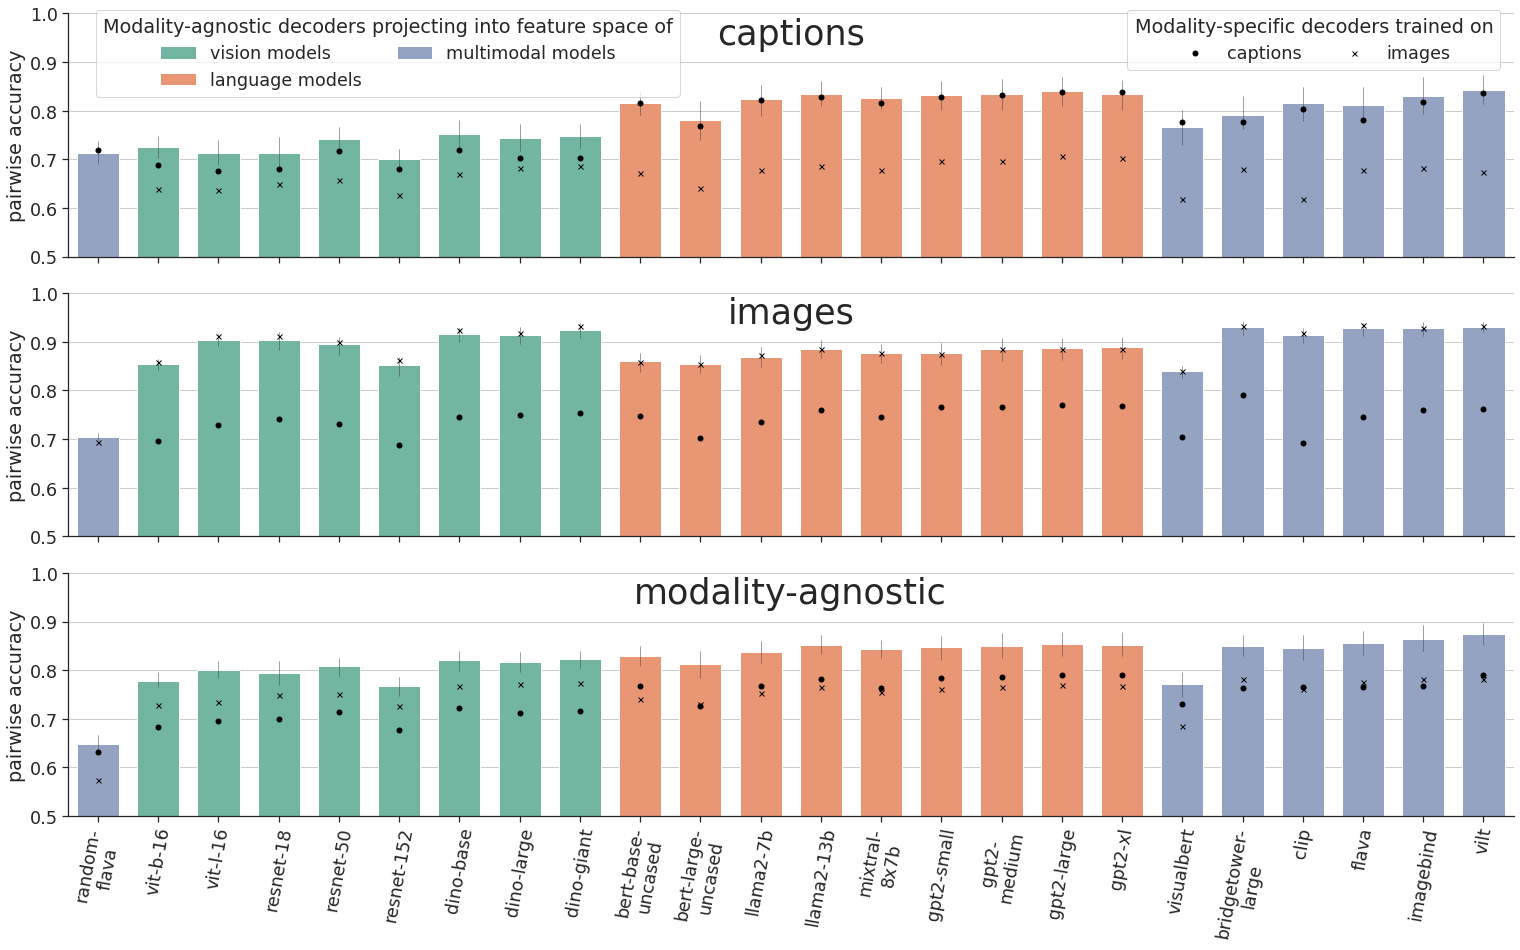

In [9]:
sns.set(font_scale=1.6)
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

# MODEL_FEATS_EXCLUDED = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang"] + MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY
# data_to_plot = all_data[~all_data.model_feat.isin(MODEL_FEATS_EXCLUDED)].copy()
data_to_plot = data_default_feats.copy()

# data_to_plot = data_to_plot[data_to_plot.vision_features == 'visual_feature_mean']
# data_to_plot = data_to_plot[(data_to_plot.model == "flava") & (data_to_plot.vision_features == 'visual_feature_cls') | (data_to_plot.model != "flava") & (data_to_plot.vision_features == 'visual_feature_mean')]


data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models", "matched": "multimodal models"})

data_to_plot = data_to_plot[data_to_plot["mask"] == "whole_brain"]
model_feat_order = calc_model_feat_order(data_to_plot)

# metrics_order = [ACC_CAPTIONS, ACC_IMAGES, ACC_MEAN, ACC_MODALITY_AGNOSTIC]
metrics_order = [ACC_CAPTIONS, ACC_IMAGES, ACC_MODALITY_AGNOSTIC]
figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,0.98), legend_2_bbox=(0.99,0.98), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)


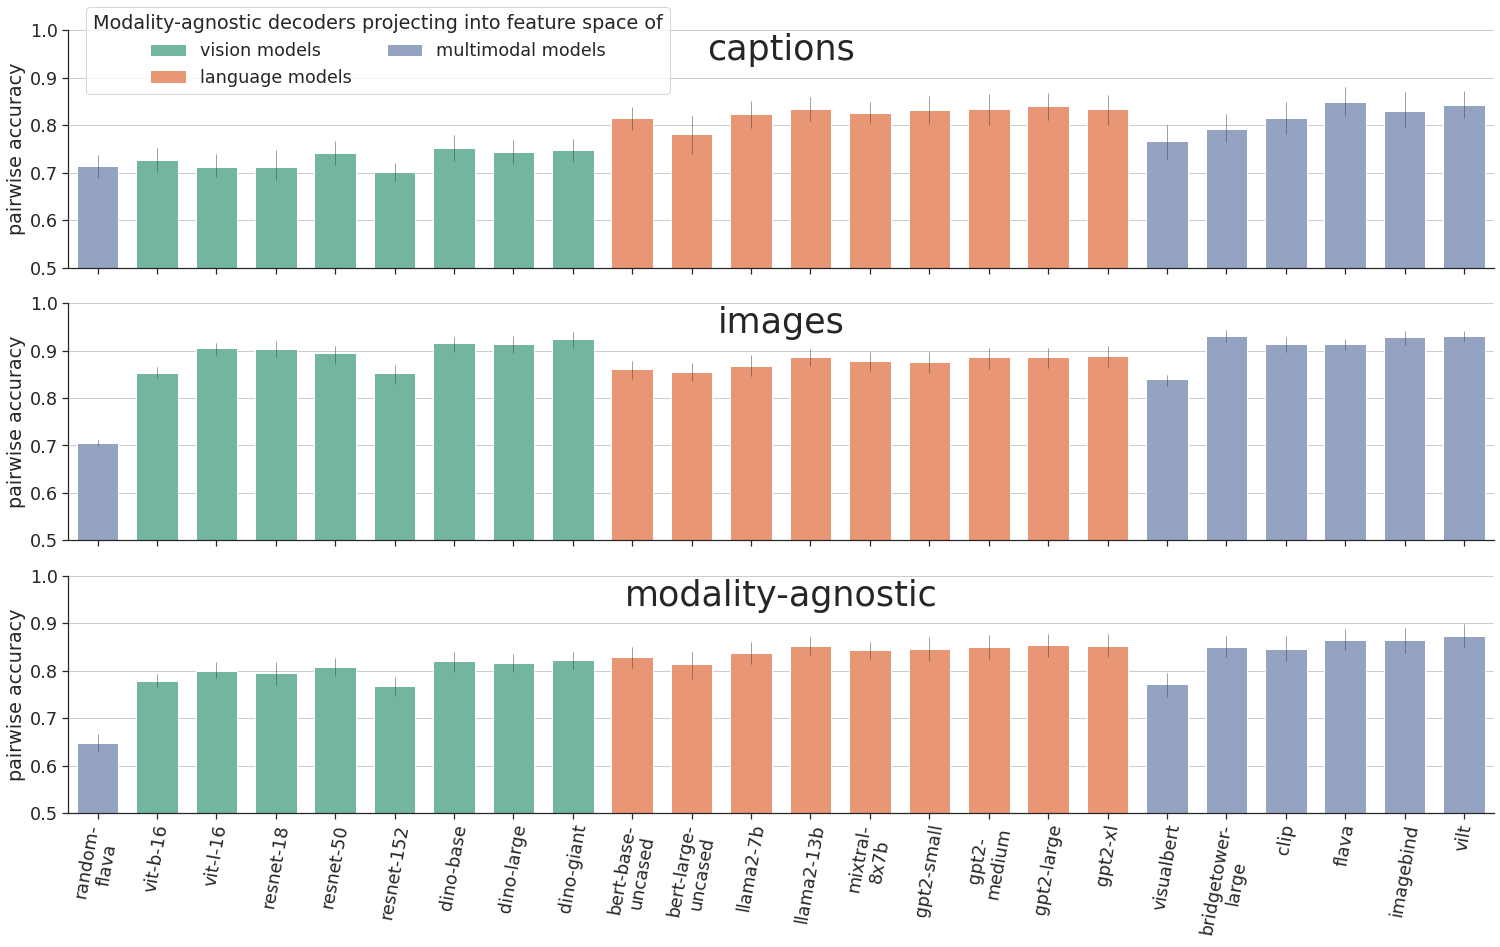

In [10]:
sns.set(font_scale=1.6)
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

MODEL_FEATS_EXCLUDED = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang"] + MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY
data_to_plot = all_data[~all_data.model_feat.isin(MODEL_FEATS_EXCLUDED)].copy()

data_to_plot = data_to_plot[data_to_plot.vision_features == 'visual_feature_mean']

# data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models", "vision+lang": "multimodal models"})
data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models", "matched": "multimodal models"})

data_to_plot = data_to_plot[data_to_plot["mask"] == "whole_brain"]
model_feat_order = calc_model_feat_order(data_to_plot)

# metrics_order = [ACC_CAPTIONS, ACC_IMAGES, ACC_MEAN, ACC_MODALITY_AGNOSTIC]
metrics_order = [ACC_CAPTIONS, ACC_IMAGES, ACC_MODALITY_AGNOSTIC]
figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1),
                             legend_bbox=(0.06,0.99), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False,
                                 plot_modality_specific=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_only_modality_agnostic.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


## V, L, or multimodal feats for multimodal models

/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)
/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:26: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:26: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
/home/mitja/multimodal_decoding/noteb

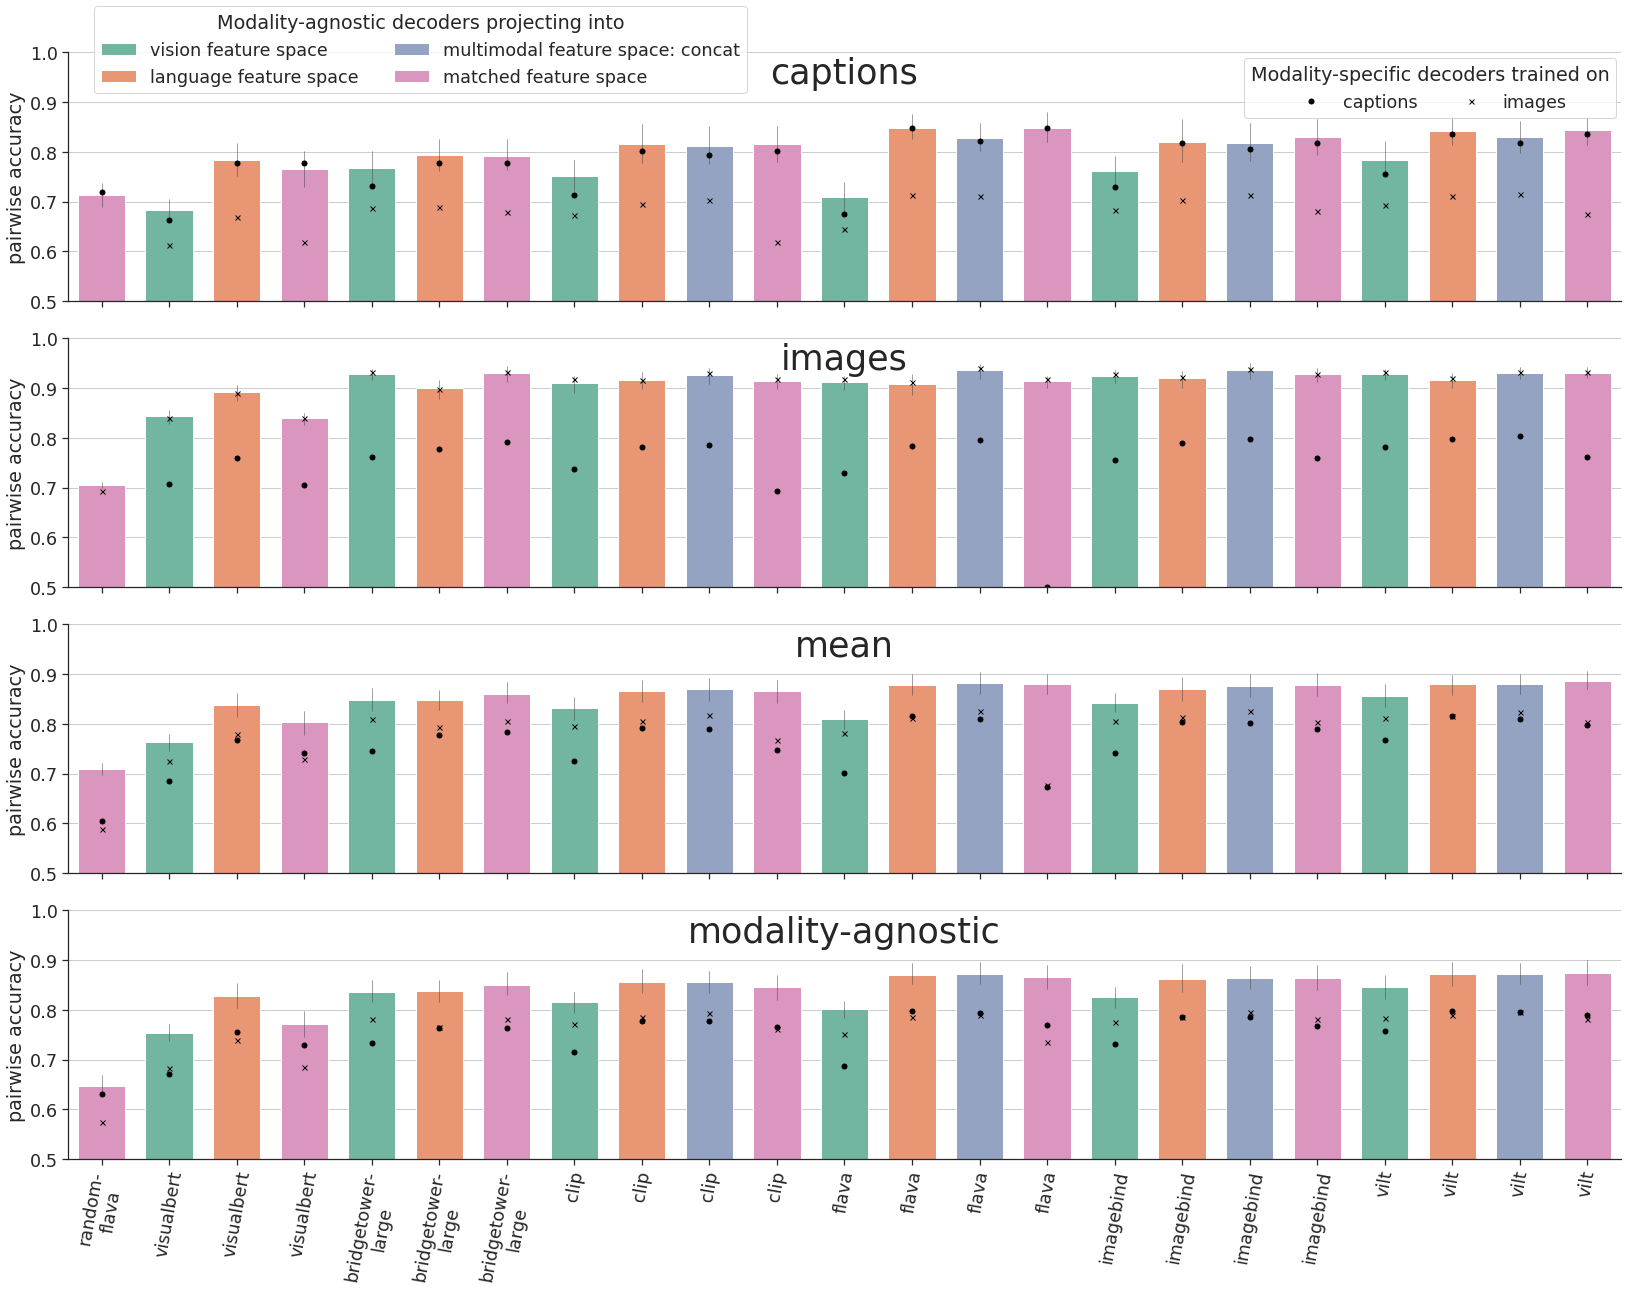

In [11]:
feat_legend = {"vision": "vision feature space", "lang": "language feature space", "vision+lang": "multimodal feature space: concat", "matched": "matched feature space"}
feat_order = ["vision", "lang", "vision+lang", "matched"]
feat_order_long = [feat_legend[feat] for feat in feat_order]

model_feats_exluded = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang", "random-flava_vision+lang"]
data_to_plot = all_data[~all_data.model_feat.isin(model_feats_exluded)].copy()

data_to_plot = data_to_plot[data_to_plot.model.isin(multimodal_models)]
data_to_plot = data_to_plot[data_to_plot.vision_features == 'visual_feature_mean']

data_to_plot["features"] = data_to_plot.features.replace(feat_legend)

data_to_plot = data_to_plot[data_to_plot["mask"] == "whole_brain"]
model_feat_order = calc_model_feat_order(data_to_plot, feat_options=feat_order)

metrics_order = [ACC_CAPTIONS, ACC_IMAGES, ACC_MEAN, ACC_MODALITY_AGNOSTIC]
figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=feat_order_long, ylim=(0.5, 1),
                             legend_bbox=(0.06,1.01), height=4.5, legend_title="Modality-agnostic decoders projecting into", verify_num_datapoints=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_multimodal_models.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

## CLS or mean feats for vision models

/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:65: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.catplot(data_filtered, kind=kind, x=x_variable, order=order, y="value", row=row_variable, row_order=row_order, col=col_variable, height=height, aspect=aspect, hue=hue_variable, hue_order=hue_order,


AttributeError: 'NoneType' object has no attribute 'remove'

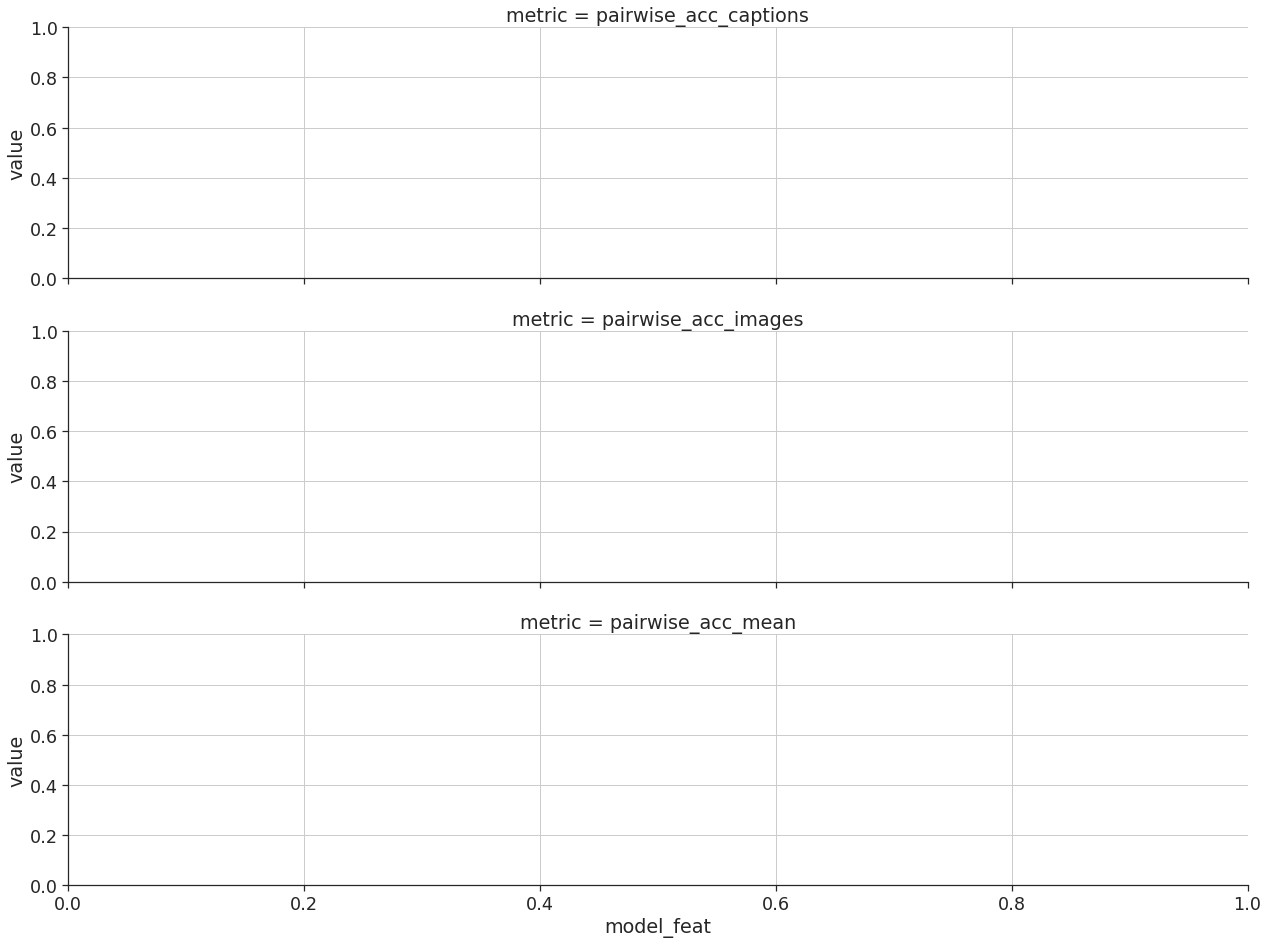

In [12]:
model_feats_exluded = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang", "random-flava_vision+lang"]
data_to_plot = all_data[~all_data.model_feat.isin(model_feats_exluded)].copy()

vision_models_both_options = [m for m in vision_models if len(data_to_plot[data_to_plot.model == m].vision_features.unique()) == 2]
data_to_plot = data_to_plot[data_to_plot.model.isin(vision_models_both_options)]

vision_feat_order = ["Mean vision features", "CLS token vision features"]
data_to_plot["vision_features"] = data_to_plot.vision_features.replace({"visual_feature_mean": "Mean vision features", "visual_feature_cls": "CLS token vision features"})

data_to_plot = data_to_plot[data_to_plot.training_mode == "modality-agnostic"]

data_to_plot = data_to_plot[data_to_plot["mask"] == "whole_brain"]
model_feat_order = calc_model_feat_order(data_to_plot)

metrics_order = ["pairwise_acc_captions", "pairwise_acc_images", ACC_MEAN]
figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_variable="vision_features", hue_order=vision_feat_order, ylim=(0.5, 1),
                             legend_bbox=(0.06,1.0), height=4.5, legend_title="Modality-agnostic decoders projecting into", plot_modality_specific=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_vision_models.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

## ROI-based decoding

In [ ]:
MASK_ORDER = ["high-level visual ROI", "low-level visual ROI", "language ROI"]
# MASK_ORDER = ["high-level visual ROI", "low-level visual ROI", "language ROI", "functional_Language", "functional_Visual1", "functional_Visual2", "functional_Default", "functional_Visual1_Visual2"]

MASK_PALETTE = sns.color_palette('Set2')[3:3+len(MASK_ORDER)][::-1]

# data_all_masks = all_data[all_data.model_feat.isin(MODEL_FEATS_INCLUDED)].copy()

MODEL_FEATS_EXCLUDED = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang"] + MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY
data_all_masks = all_data[~all_data.model_feat.isin(MODEL_FEATS_EXCLUDED)].copy()

data_all_masks = data_all_masks[data_all_masks.vision_features == 'visual_feature_mean']


data_all_masks["mask"] = data_all_masks["mask"].replace({"anatomical_visual_low_level": "low-level visual ROI", "anatomical_lang": "language ROI", "anatomical_visual_high_level": "high-level visual ROI"})

data_all_masks = data_all_masks[data_all_masks["mask"].isin(MASK_ORDER)].copy()

model_feat_order = calc_model_feat_order(data_all_masks)

metrics_order = ["pairwise_acc_captions", "pairwise_acc_images", ACC_MEAN]

dodge = 0.47
# dodge = 0.6
figure, lgd = create_result_graph(data_all_masks, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_variable="mask", hue_order=MASK_ORDER, palette=MASK_PALETTE, ylim=(0.5, 1),
                                  legend_title="Modality-agnostic decoders trained on fMRI data from", dodge=dodge, legend_bbox=(0.06,0.99))

colors_bg = sns.color_palette('Set2')[:3]
for i in range(len(figure.axes)):
    figure.axes[i, 0].axvspan(-0.5, 0.5, facecolor=colors_bg[2], alpha=0.2, zorder=-100)
    figure.axes[i, 0].axvspan(0.5, 8.5, facecolor=colors_bg[0], alpha=0.2, zorder=-100)
    figure.axes[i, 0].axvspan(8.5, 18.5, facecolor=colors_bg[1], alpha=0.2, zorder=-100)
    figure.axes[i, 0].axvspan(18.5, 25.5, facecolor=colors_bg[2], alpha=0.2, zorder=-100)
plt.xlim((-0.5, 25.5))


# plt.subplots_adjust(top=0.98, bottom=0.05, hspace=0)
plt.savefig(os.path.join(RESULTS_DIR, f"roi_comparison_pairwise_acc.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

In [ ]:
n_voxels_data = data_all_masks[~data_all_masks.num_voxels.isna()]
n_voxels_data = {mask: n_voxels_data[n_voxels_data["mask"] == mask].num_voxels.mean() for mask in n_voxels_data["mask"].unique()}
# n_voxels_data.update({
#     # "whole_brain": 214739,
#     "visual_high_level": 14698,
#     "visual_low_level": 13955
# })
print(n_voxels_data)
# sns.barplot(data=n_voxels_data)
# # plt.yscale("log")
# plt.xticks(rotation = 80)
# plt.ylabel("num voxels")
# plt.title("Number of voxels for each mask (whole brain: 214,739)")
# plt.tight_layout()
# plt.savefig(os.path.join(RESULTS_DIR, f"num_voxels.png"), dpi=300)

## Per-subject results

In [ ]:
FEAT_ORDER = ["vision", "lang", "matched"]
FEAT_PALETTE = sns.color_palette('Set2')[:3]

def create_result_graph_all_subjs(data, model_feat_order, metrics=["pairwise_acc_captions", "pairwise_acc_images"], hue_variable="features", hue_order=FEAT_ORDER, ylim=None,
                        legend_title="Modality-agnostic decoders based on features from", palette=FEAT_PALETTE, dodge=False, noise_ceilings=None, plot_modality_specific=True,
                       row_variable="metric", col_variable=None):
    data_training_mode_full = data[data.training_mode == "modality-agnostic"]


    assert len(data_training_mode_full[(data_training_mode_full.model_feat == 'gpt2-large_lang') & (data_training_mode_full.metric == metrics[0]) & (data_training_mode_full[hue_variable] == data_training_mode_full[hue_variable].values[0])]) == 6

    catplot_g, data_plotted, lgd = plot_metric_catplot(data_training_mode_full, order=model_feat_order, metrics=metrics, x_variable="model_feat", legend_title=legend_title, aspect=2, legend_bbox=(0,1.05), rotation=89, cut_labels=False,
                                                  hue_variable=hue_variable, row_variable=row_variable, col_variable=col_variable, hue_order=hue_order, palette=palette, ylim=ylim, noise_ceilings=noise_ceilings)

    if plot_modality_specific:
        for i, subj in zip(range(6), SUBJECTS):
            data_subj = data[data.subject == subj]
            data_training_mode_captions = data_subj[data_subj.training_mode == "captions"]
            data_training_mode_images = data_subj[data_subj.training_mode == "images"]
            _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[i, 0], marker="o", plot_legend=False, ylim=ylim)
            g, _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[i, 0], marker="x", plot_legend=False, ylim=ylim)
            
            _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[i, 1], marker="o", plot_legend=False, ylim=ylim)
            _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[i, 1], marker="x", plot_legend=False, ylim=ylim)
        
        handles, labels = g.get_legend_handles_labels()
        new_labels = ["captions", "images"]
        new_handles = [handles[0], handles[-1]]
        catplot_g.fig.legend(handles=new_handles, labels=new_labels, ncol=2, title="Modality-specific decoders trained on", loc='upper right')

        for i in range(6):
            catplot_g.axes[i,0].set_title(f"subject {i+1} | captions", fontsize=25)
            catplot_g.axes[i,1].set_title(f"subject {i+1} | images", fontsize=25)

            catplot_g.axes[i,0].set_ylabel('pairwise accuracy')

    return catplot_g, lgd


In [ ]:
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision model", "language model", "multimodal model"]

MODEL_FEATS_EXCLUDED = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang"] + MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY
data_to_plot = all_data[~all_data.model_feat.isin(MODEL_FEATS_EXCLUDED)].copy()

data_to_plot = data_to_plot[data_to_plot.vision_features == 'visual_feature_mean']

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision model", "lang": "language model", "matched": "multimodal model"})

data_to_plot = data_to_plot[data_to_plot["mask"] == "whole_brain"]
model_feat_order = calc_model_feat_order(data_to_plot)

figure, lgd = create_result_graph_all_subjs(data_to_plot, model_feat_order, metrics=["pairwise_acc_captions", "pairwise_acc_images"], hue_order=FEAT_ORDER, ylim=(0.5, 1), row_variable="subject", col_variable="metric")
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_per_subject.png"), dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0)